# Titanic - Machine Learning from Disaster

https://www.kaggle.com/competitions/titanic

https://www.kaggle.com/competitions/titanic/data

Sources of inspiration:
- https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook?scriptVersionId=27280410
- https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb

In [1]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    LabelEncoder,
    FunctionTransformer,
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler
)
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42

## Download dataset

In [2]:
import kagglehub
path = kagglehub.competition_download("titanic")
path

'/home/martin/.cache/kagglehub/competitions/titanic'

In [135]:
train_data = pd.read_csv(os.path.join(path, "train.csv"))
train_data.shape

(891, 12)

In [136]:
test_data = pd.read_csv(os.path.join(path, "test.csv"))
test_data.shape

(418, 11)

## Explore data

In [137]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [138]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [139]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

# The goal of the competition is to predict Survival based on test_data.
# We wouldn't have that kind of luxury in real world and we would stay away from test_data as far as we can (so that we can prepare for production data).
# Here however, we should include the test_data, in exploration, augmentation and feature creation (so that we are best prepared for the test data).
all_data = concat_df(train_data, test_data)

### Survival rate based on Sex

In [140]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [141]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


## Prepare the Data for Machine Learning Algorithms

### Feature Engineering

#### Title

As mentioned in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=58),
title *Master* tells us that a person is a small boy. Also, we can learn whether woman is married or unmarried.

In [143]:
all_data["Title"] = (
    all_data["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
)

# This should retain information for most prevalant ones but remove the outliers
all_data["Title"] = (
    all_data["Title"]
    .replace(
        ["Mrs", "Lady", "Mme", "the Countess", "Dona"],
        "Married woman",
    )
    .replace(["Miss", "Mlle", "Ms"], "Unmarried woman")
    .replace(
        ["Dr", "Col", "Major", "Jonkheer", "Capt", "Sir", "Don", "Rev"],
        "Dr/Military/Noble/Clergy",
    )
)

In [144]:
all_data["Title"].value_counts()

Title
Mr                          757
Unmarried woman             264
Married woman               201
Master                       61
Dr/Military/Noble/Clergy     26
Name: count, dtype: int64

#### Families

In [203]:
all_data["Parch"].value_counts()

Parch
0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: count, dtype: int64

In [201]:
all_data["Parch_Parents"] = all_data["Parch"].transform({lambda x: 1 if x > 2 else 0})

In [202]:
all_data["Parch_Parents"].value_counts()

Parch_Parents
0    1285
1      24
Name: count, dtype: int64

In [205]:
all_data["Family_Size"] = all_data["SibSp"] + all_data["Parch"] + 1

In [206]:
all_data["Family_Size"].value_counts()

Family_Size
1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: count, dtype: int64

### Missing values

In [145]:
all_data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Title             0
dtype: int64

#### Age

#### Cabin

**New Deck Feature**

Cabin alone doesn't give us a lot of information, but we can extract Deck from that feature which better correlates with other features.

**Missing Cabin values**

As noted in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=22),
people with missing Cabin value have low survival rate, so it can be a good feature and let's do the same and create special category for them (instead of replacing it with most common).

In [146]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
all_data["Deck"] = all_data["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else 'M')

**Deck T**

As noted in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=22),
"There is one person on the boat deck in T cabin and he is a 1st class passenger. T cabin passenger has the closest resemblance to A deck passengers so he is grouped with A deck".

In [147]:
# Passenger in the T deck is changed to A
idx = all_data[all_data["Deck"] == 'T'].index
all_data.loc[idx, "Deck"] = 'A'

In [148]:
all_data_copy = all_data.copy()

all_data_copy["Deck_Num"] = LabelEncoder().fit_transform(all_data_copy["Deck"])
all_data_copy["Cabin_Num"] = LabelEncoder().fit_transform(all_data_copy["Cabin"])

corr_matrix = all_data_copy.corr(numeric_only=True)
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Cabin_Num     -0.253406
Deck_Num      -0.290485
Pclass        -0.338481
Name: Survived, dtype: float64

#### Embarked

Just replace NaN with most common value.

In [149]:
all_data["Embarked"] = all_data["Embarked"].fillna(all_data["Embarked"].mode().iloc[0])

In [150]:
all_data.isnull().sum()

Age             263
Cabin          1014
Embarked          0
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Title             0
Deck              0
dtype: int64

#### Fare

In [151]:
# Filling the missing values in Fare with the medians of related groups
all_data["Fare"] = all_data.groupby(['Pclass', 'Parch', 'SibSp'])["Fare"].transform(lambda x: x.fillna(x.median()))

In [152]:
all_data.isnull().sum()

Age             263
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Title             0
Deck              0
dtype: int64

As mentioned in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=47),
13 should give use enough information (as proven by having similar correlation with "Survived" as logarithmic Fare).

In [153]:
all_data["Fare_Grouped"] = pd.qcut(all_data['Fare'], 13)
all_data["Fare_Grouped"] = LabelEncoder().fit_transform(all_data["Fare_Grouped"])

In [154]:
# TODO: compare if it is better to use "Fare_Log" or "Fare_Grouped" (intuitively I would say that Random Forest should be allowed to slice continuous values itself)
# Fare is skewed slightly to the left so log function will fix it to resemble bell curve (ML models work with that better).
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
all_data["Fare_Log"] = log_transformer.transform(all_data[["Fare"]])

/home/martin/miniconda/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [207]:
corr_matrix = all_data.corr(numeric_only=True)
corr_matrix["Survived"].sort_values(ascending=False)

Survived         1.000000
Fare_Log         0.325452
Fare_Grouped     0.321206
Fare             0.257307
Parch            0.081629
Family_Size      0.016639
PassengerId     -0.005007
Parch_Parents   -0.031528
SibSp           -0.035322
Age             -0.077221
Pclass          -0.338481
Name: Survived, dtype: float64

## Train and evaluate different models

In [156]:
num_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [157]:
cat_pipeline = Pipeline(
    [
        ("ordinal_encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ]
)

In [231]:
num_attribs = ["Age", "Fare", "Family_Size"]
cat_attribs = ["Pclass", "Sex", "Embarked", "Deck", "Title"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ], remainder='passthrough', verbose_feature_names_out=False)

In [232]:
transformed_data = preprocess_pipeline.fit_transform(all_data)

transformed_data_df = pd.DataFrame(
    transformed_data,
    columns=preprocess_pipeline.get_feature_names_out(),
    index=all_data.index,
).drop(["Cabin", "Name", "Ticket", "Fare_Log", "Fare_Grouped", "Parch_Parents", "SibSp", "Parch"], axis=1)

train_data, test_data = divide_df(transformed_data_df)

X = train_data.drop(["Survived", "PassengerId"], axis=1)
y = train_data["Survived"].copy().astype("int64")

X_test = test_data.drop(["PassengerId"], axis=1)

In [234]:
X.columns

Index(['Age', 'Fare', 'Family_Size', 'Pclass_0.0', 'Pclass_1.0', 'Pclass_2.0',
       'Sex_0.0', 'Sex_1.0', 'Embarked_0.0', 'Embarked_1.0', 'Embarked_2.0',
       'Deck_0.0', 'Deck_1.0', 'Deck_2.0', 'Deck_3.0', 'Deck_4.0', 'Deck_5.0',
       'Deck_6.0', 'Deck_7.0', 'Title_0.0', 'Title_1.0', 'Title_2.0',
       'Title_3.0', 'Title_4.0'],
      dtype='object')

### Logistic Regression

In [235]:
lg_model = LogisticRegression(random_state=RANDOM_STATE)
lg_model.fit(X, y)

LogisticRegression(random_state=42)

### Decision Tree

In [236]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X, y)

DecisionTreeClassifier()

### Random forest classifier

In [237]:
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)
rfc_model.fit(X, y)

RandomForestClassifier(max_depth=5, random_state=42)

In [238]:
feature_importances = rfc_model.feature_importances_

sorted(zip(feature_importances,
           transformed_data_df),
           reverse=True)

[(0.17578276197032397, 'Title_3.0'),
 (0.15715307345634408, 'Sex_0.0'),
 (0.15470085523295254, 'Sex_1.0'),
 (0.06851886761796744, 'Pclass_2.0'),
 (0.06330328230969982, 'Fare'),
 (0.061532861594229195, 'Family_Size'),
 (0.05258003108484883, 'Title_4.0'),
 (0.050547773250974606, 'Title_1.0'),
 (0.048633039788909906, 'Deck_7.0'),
 (0.04859490626835115, 'Age'),
 (0.028059454480550392, 'Pclass_0.0'),
 (0.020491704490094426, 'Pclass_1.0'),
 (0.015318087311555768, 'Title_2.0'),
 (0.010952047968861688, 'Embarked_0.0'),
 (0.008713640222631023, 'Embarked_2.0'),
 (0.008197143623511033, 'Deck_4.0'),
 (0.005446175777837133, 'Deck_1.0'),
 (0.0047314088729553255, 'Title_0.0'),
 (0.00412883090925437, 'Embarked_1.0'),
 (0.0040879325325667406, 'Deck_2.0'),
 (0.0036073293128439103, 'Deck_3.0'),
 (0.0019077976492277917, 'Deck_6.0'),
 (0.0018450515295698796, 'Deck_5.0'),
 (0.001165942743939088, 'Deck_0.0')]

### Support Vector Classifier

In [239]:
svc_model = SVC(gamma="auto", random_state=RANDOM_STATE)
svc_model.fit(X, y)

SVC(gamma='auto', random_state=42)

### K-Nearest Neighbors Classifier

In [240]:
knc_model = KNeighborsClassifier(n_neighbors=3)
knc_model.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

### Comparision

In [241]:
lg_scores = cross_val_score(lg_model, X, y, cv=10, scoring="accuracy")
print(f"Logistic Regression Mean: {lg_scores.mean()}")

dtc_scores = cross_val_score(dtc_model, X, y, cv=10, scoring="accuracy")
print(f"Decision Tree Mean: {dtc_scores.mean()}")

rfc_scores = cross_val_score(rfc_model, X, y, cv=10, scoring="accuracy")
print(f"Random Forest Mean: {rfc_scores.mean()}")

svc_scores = cross_val_score(svc_model, X, y, cv=10, scoring="accuracy")
print(f"SVM Mean: {svc_scores.mean()}")

knc_scores = cross_val_score(knc_model, X, y, cv=10, scoring="accuracy")
print(f"K-Nearest Neighbors Mean: {knc_scores.mean()}")

Logistic Regression Mean: 0.8316604244694134
Decision Tree Mean: 0.7801248439450686
Random Forest Mean: 0.8271785268414481
SVM Mean: 0.8372659176029963
K-Nearest Neighbors Mean: 0.8204744069912608


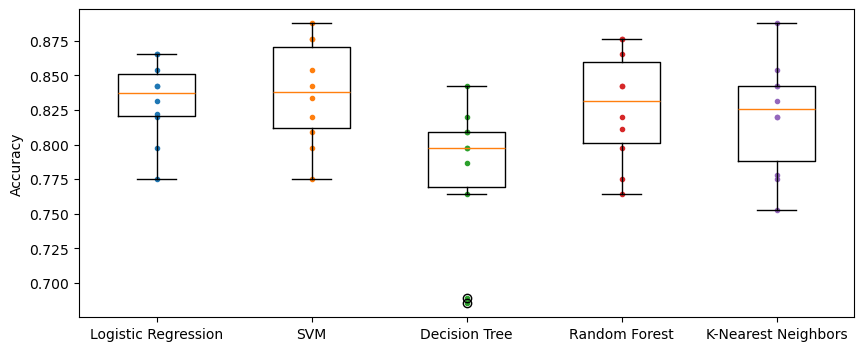

In [242]:
plt.figure(figsize=(10, 4))
plt.plot([1] * 10, lg_scores, ".")
plt.plot([2] * 10, svc_scores, ".")
plt.plot([3] * 10, dtc_scores, ".")
plt.plot([4] * 10, rfc_scores, ".")
plt.plot([5] * 10, knc_scores, ".")
plt.boxplot(
    [lg_scores, svc_scores, dtc_scores, rfc_scores, knc_scores],
    tick_labels=(
        "Logistic Regression",
        "SVM",
        "Decision Tree",
        "Random Forest",
        "K-Nearest Neighbors"
    ),
)
plt.ylabel("Accuracy")
plt.show()

In [243]:
final_model = rfc_model

## Upload new submission

In [244]:
predictions = final_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype('int64')})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


| WARNING: Don't forget to change "changeId" so that we can track version of jupyter book this submission is from! |
| --- |

In [245]:
# In case we run this cell by accident, this script disables its execution - comment out to enable it again
%%script false --no-raise-error

from kaggle.api.kaggle_api_extended import KaggleApi

changeId = "bbb1c5840d4511156a63118201795cb8ac001387"

api = KaggleApi()
api.authenticate()

# kaggle competitions submit -c titanic -f submission.csv -m "Message"
api.competition_submit(file_name="submission.csv", message=f"ChangeId: {changeId}", competition="titanic")

UsageError: Line magic function `%%script` not found.
